In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
import nltk
import re
import string
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

from nltk.stem import PorterStemmer


stop_words = stopwords.words()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("crowdflower/twitter-airline-sentiment")

print("Path to dataset files:", path)

100%|██████████| 2.55M/2.55M [00:00<00:00, 42.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/crowdflower/twitter-airline-sentiment/versions/4


In [3]:
import os

# Check downloaded files
if os.path.exists(path):
    files = os.listdir(path)
    print("Files in dataset folder:", files)
else:
    print("Download path does not exist:", path)


Files in dataset folder: ['Tweets.csv', 'database.sqlite']


In [4]:
csv_file = os.path.join(path, "Tweets.csv")

In [5]:
df = pd.read_csv(csv_file)

df.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

# Data Preprocessing


1.    Convert text to lowercase
2.   Remove punctuation
3.   Remove numbers
4.  Remove extra spaces


In [7]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

In [8]:
def preprocess_text(text):
    # Remove URLs and non-alphanumeric characters
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    # Remove stop words and stem the words
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing

In [9]:
df['text'] = df['text'].apply(preprocess_text)
df['airline_sentiment'].value_counts()

,count
airline_sentiment,
negative,9178
neutral,3099
positive,2363


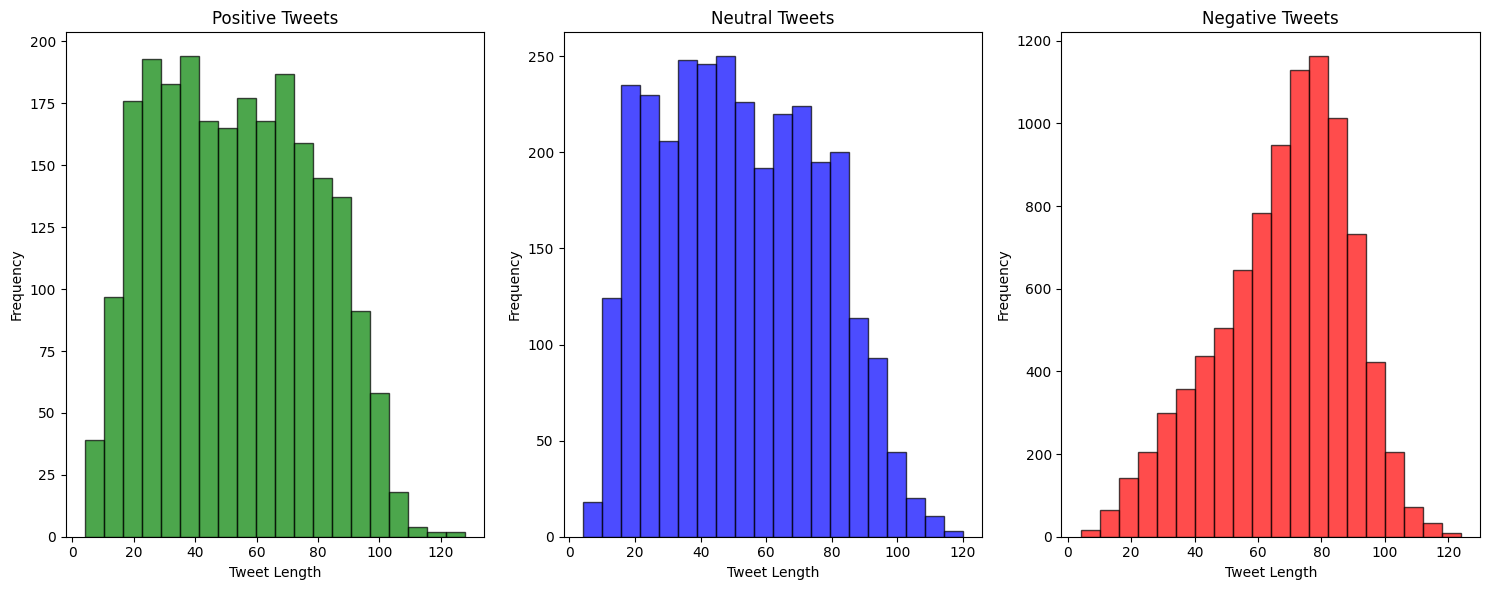

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))
ax1.hist(df[df['airline_sentiment'] == 'positive']['text'].str.len(), color='green', bins=20, alpha=0.7, edgecolor='black')
ax1.set_title('Positive Tweets')
ax1.set_xlabel('Tweet Length')
ax1.set_ylabel('Frequency')

ax2.hist(df[df['airline_sentiment'] == 'neutral']['text'].str.len(), color='blue', bins=20, alpha=0.7, edgecolor='black')
ax2.set_title('Neutral Tweets')
ax2.set_xlabel('Tweet Length')
ax2.set_ylabel('Frequency')

ax3.hist(df[df['airline_sentiment'] == 'negative']['text'].str.len(), color='red', bins=20, alpha=0.7, edgecolor='black')
ax3.set_title('Negative Tweets')
ax3.set_xlabel('Tweet Length')
ax3.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


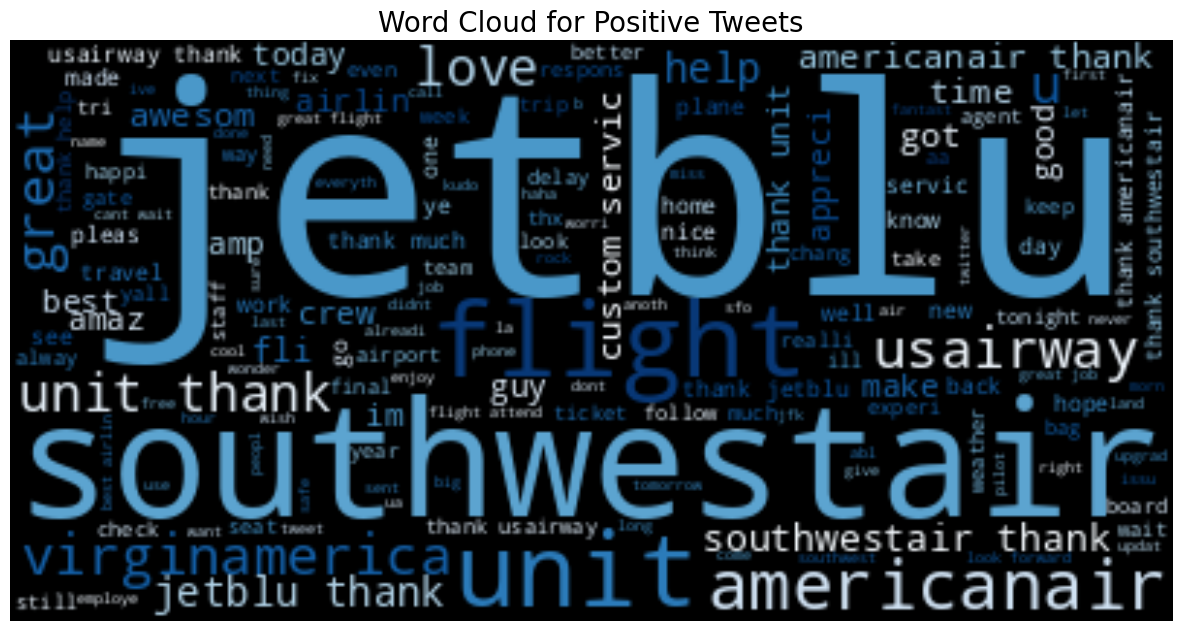

In [11]:
text = " ".join(i for i in df[df['airline_sentiment'] == 'positive']['text'])
wordcloud = WordCloud(background_color="black", colormap='Blues', max_font_size=100, max_words=300, contour_width=3, contour_color='steelblue').generate(text)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Positive Tweets', fontsize=20)
plt.show()

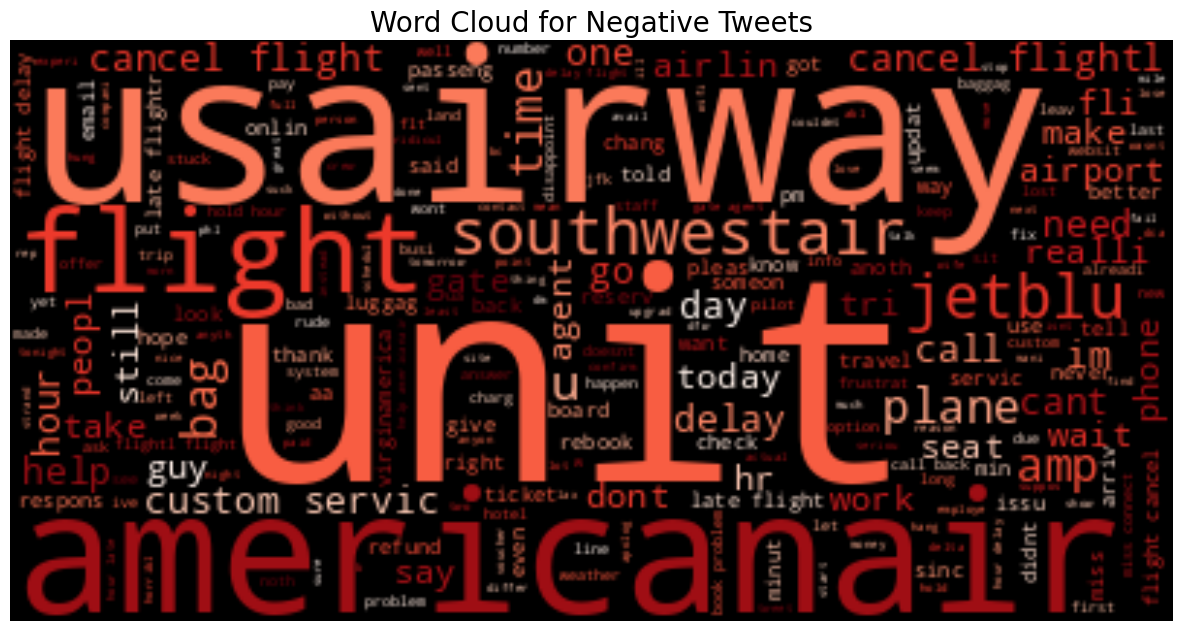

In [12]:
from wordcloud import  STOPWORDS
stopwords = set(STOPWORDS)
text = " ".join(i for i in df[df['airline_sentiment'] == 'negative']['text'])
wordcloud = WordCloud(stopwords=stopwords, background_color="black", colormap='Reds', max_font_size=100, max_words=300, contour_width=3, contour_color='firebrick').generate(text)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Negative Tweets', fontsize=20)
plt.show()

# Create a new DataFrame with selected columns

In [13]:
dt = df['text']
dt = pd.DataFrame(dt)
dt['airline_sentiment']=df['airline_sentiment']
dt

,text,airline_sentiment
0,virginamerica dhepburn said,neutral
1,virginamerica plu youv ad commerci experi tacki,positive
2,virginamerica didnt today must mean need take ...,neutral
3,virginamerica realli aggress blast obnoxi ente...,negative
4,virginamerica realli big bad thing,negative
...,...,...
14635,americanair thank got differ flight chicago,positive
14636,americanair leav minut late flight warn commun...,negative
14637,americanair pleas bring american airlin blackb...,neutral
14638,americanair money chang flight dont answer pho...,negative


In [14]:
dt['no_sw'] = dt['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [15]:
dt

,text,airline_sentiment,no_sw
0,virginamerica dhepburn said,neutral,virginamerica dhepburn said
1,virginamerica plu youv ad commerci experi tacki,positive,virginamerica plu youv ad commerci experi tacki
2,virginamerica didnt today must mean need take ...,neutral,virginamerica didnt today must mean need take ...
3,virginamerica realli aggress blast obnoxi ente...,negative,virginamerica realli aggress blast obnoxi ente...
4,virginamerica realli big bad thing,negative,virginamerica realli big bad thing
...,...,...,...
14635,americanair thank got differ flight chicago,positive,americanair thank got differ flight chicago
14636,americanair leav minut late flight warn commun...,negative,americanair leav minut late flight warn commun...
14637,americanair pleas bring american airlin blackb...,neutral,americanair pleas bring american airlin blackb...
14638,americanair money chang flight dont answer pho...,negative,americanair money chang flight dont answer pho...


In [16]:
def remove_stopwords(text):
    stop_words = set(STOPWORDS)
    return ' '.join([word for word in text.split() if word not in stop_words])


In [17]:
cnt = Counter()
for text in dt["no_sw"].values:
    for word in text.split():
        cnt[word] += 1
cnt.most_common(10)
temp = pd.DataFrame(cnt.most_common(10))
temp.columns=['word', 'count']

temp


,word,count
0,flight,4808
1,unit,4152
2,usairway,3052
3,americanair,2958
4,southwestair,2456
5,jetblu,2391
6,thank,1689
7,get,1617
8,hour,1151
9,cancel,1056


In [18]:
fig = px.bar(temp, x='count', y='word', title='Common Words in Text', orientation='h',
             width=800, height=600, color='count', color_continuous_scale='Viridis',
             template='plotly_dark')
fig.update_layout(title_font_size=20, xaxis_title='Count', yaxis_title='Word', title_x=0.5)
fig.show()


In [19]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])

def remove_freqwords(text):
    """Custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

In [20]:
dt['wo_stopfreq'] = dt['no_sw'].apply(lambda text: remove_freqwords(text))
dt.head()

,text,airline_sentiment,no_sw,wo_stopfreq
0,virginamerica dhepburn said,neutral,virginamerica dhepburn said,virginamerica dhepburn said
1,virginamerica plu youv ad commerci experi tacki,positive,virginamerica plu youv ad commerci experi tacki,virginamerica plu youv ad commerci experi tacki
2,virginamerica didnt today must mean need take ...,neutral,virginamerica didnt today must mean need take ...,virginamerica didnt today must mean need take ...
3,virginamerica realli aggress blast obnoxi ente...,negative,virginamerica realli aggress blast obnoxi ente...,virginamerica realli aggress blast obnoxi ente...
4,virginamerica realli big bad thing,negative,virginamerica realli big bad thing,virginamerica realli big bad thing


In [21]:
#TF-IDF vectors
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text'])
y = df['airline_sentiment']

In [22]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

wordnet_lem = WordNetLemmatizer()

dt['wo_stopfreq_lem'] = dt['wo_stopfreq'].apply(wordnet_lem.lemmatize)
dt

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


,text,airline_sentiment,no_sw,wo_stopfreq,wo_stopfreq_lem
0,virginamerica dhepburn said,neutral,virginamerica dhepburn said,virginamerica dhepburn said,virginamerica dhepburn said
1,virginamerica plu youv ad commerci experi tacki,positive,virginamerica plu youv ad commerci experi tacki,virginamerica plu youv ad commerci experi tacki,virginamerica plu youv ad commerci experi tacki
2,virginamerica didnt today must mean need take ...,neutral,virginamerica didnt today must mean need take ...,virginamerica didnt today must mean need take ...,virginamerica didnt today must mean need take ...
3,virginamerica realli aggress blast obnoxi ente...,negative,virginamerica realli aggress blast obnoxi ente...,virginamerica realli aggress blast obnoxi ente...,virginamerica realli aggress blast obnoxi ente...
4,virginamerica realli big bad thing,negative,virginamerica realli big bad thing,virginamerica realli big bad thing,virginamerica realli big bad thing
...,...,...,...,...,...
14635,americanair thank got differ flight chicago,positive,americanair thank got differ flight chicago,got differ chicago,got differ chicago
14636,americanair leav minut late flight warn commun...,negative,americanair leav minut late flight warn commun...,leav minut late warn commun minut late call sh...,leav minut late warn commun minut late call sh...
14637,americanair pleas bring american airlin blackb...,neutral,americanair pleas bring american airlin blackb...,pleas bring american airlin blackberri,pleas bring american airlin blackberri
14638,americanair money chang flight dont answer pho...,negative,americanair money chang flight dont answer pho...,money chang dont answer phone suggest make commit,money chang dont answer phone suggest make commit


In [23]:
mapping = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

dn=dt.drop(columns=['text','no_sw', 'wo_stopfreq'])
dn.columns=['airline_sentiment','text']

dn['airline_sentiment'] = dn['airline_sentiment'].map(mapping)


dn



,airline_sentiment,text
0,1,virginamerica dhepburn said
1,2,virginamerica plu youv ad commerci experi tacki
2,1,virginamerica didnt today must mean need take ...
3,0,virginamerica realli aggress blast obnoxi ente...
4,0,virginamerica realli big bad thing
...,...,...
14635,2,got differ chicago
14636,0,leav minut late warn commun minut late call sh...
14637,1,pleas bring american airlin blackberri
14638,0,money chang dont answer phone suggest make commit


In [24]:
tokenized_review=dn['text'].apply(lambda x: x.split())
tokenized_review.head(5)

,text
0,"[virginamerica, dhepburn, said]"
1,"[virginamerica, plu, youv, ad, commerci, exper..."
2,"[virginamerica, didnt, today, must, mean, need..."
3,"[virginamerica, realli, aggress, blast, obnoxi..."
4,"[virginamerica, realli, big, bad, thing]"


In [25]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(dn['text'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [26]:
# Features and Labels
X = dn['text']
y = dn['airline_sentiment']

In [27]:
# Features and Labels
# X = df['wo_stopfreq']
# y = df['airline_sentiment']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [28]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000, min_df=2, max_df=0.9)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test.values)


In [29]:
print(X_train.shape)
print(X_test.shape)

(12444,)
(2196,)


In [30]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score



text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])


In [31]:
text_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [32]:
y_pred = text_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6926229508196722
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.99      0.81      1411
           1       0.78      0.16      0.27       441
           2       0.92      0.14      0.24       344

    accuracy                           0.69      2196
   macro avg       0.80      0.43      0.44      2196
weighted avg       0.74      0.69      0.61      2196



In [33]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000, min_df=2, max_df=0.9)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [34]:
from sklearn.naive_bayes import MultinomialNB


# Train the model using Naive Bayes
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

MultinomialNB()

In [35]:
# Make predictions
y_pred = clf.predict(X_test_tfidf)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7340619307832422
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.98      0.83      1411
           1       0.73      0.26      0.38       441
           2       0.88      0.33      0.48       344

    accuracy                           0.73      2196
   macro avg       0.78      0.52      0.57      2196
weighted avg       0.75      0.73      0.69      2196



In [36]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_tfidf_res, y_train_res = smote.fit_resample(X_train_tfidf, y_train)

# Train the model using Naive Bayes with the balanced training data
clf = MultinomialNB()
clf.fit(X_train_tfidf_res, y_train_res)

# Make predictions on the test set
y_pred = clf.predict(X_test_tfidf)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.744535519125683
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.81      0.84      1411
           1       0.54      0.58      0.56       441
           2       0.58      0.69      0.63       344

    accuracy                           0.74      2196
   macro avg       0.66      0.69      0.68      2196
weighted avg       0.76      0.74      0.75      2196



In [37]:
from sklearn.ensemble import RandomForestClassifier

# إنشاء وتصحيح النموذج
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_tfidf, y_train)

# التنبؤ بالنتائج
y_pred_rf = rf_clf.predict(X_test_tfidf)

# تقييم النموذج
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.7545537340619308
              precision    recall  f1-score   support

           0       0.80      0.92      0.85      1411
           1       0.63      0.44      0.52       441
           2       0.63      0.49      0.55       344

    accuracy                           0.75      2196
   macro avg       0.69      0.62      0.64      2196
weighted avg       0.74      0.75      0.74      2196



In [38]:
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [39]:
# Make predictions
y_pred = model.predict(X_test_tfidf)

# Evaluation
print("LogisticRegression Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

LogisticRegression Accuracy: 0.7814207650273224
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.93      0.87      1411
           1       0.64      0.51      0.57       441
           2       0.77      0.50      0.61       344

    accuracy                           0.78      2196
   macro avg       0.74      0.65      0.68      2196
weighted avg       0.77      0.78      0.77      2196



In [40]:
from sklearn.svm import SVC

# إنشاء وتصحيح النموذج
svm_clf = SVC(kernel='linear', random_state=42)
svm_clf.fit(X_train_tfidf, y_train)

# التنبؤ بالنتائج
y_pred_svm = svm_clf.predict(X_test_tfidf)

# تقييم النموذج
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.7764116575591985
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1411
           1       0.62      0.53      0.57       441
           2       0.75      0.51      0.61       344

    accuracy                           0.78      2196
   macro avg       0.73      0.65      0.68      2196
weighted avg       0.77      0.78      0.77      2196



In [41]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# إعداد بيانات التدريب والاختبار باستخدام TF-IDF
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# إنشاء وتصحيح نموذج XGBoost
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)
xgb_clf.fit(X_train_tfidf, y_train)

# التنبؤ بالنتائج
y_pred_xgb = xgb_clf.predict(X_test_tfidf)

# تقييم النموذج
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.7395264116575592
              precision    recall  f1-score   support

           0       0.75      0.95      0.84      1411
           1       0.63      0.33      0.43       441
           2       0.78      0.42      0.54       344

    accuracy                           0.74      2196
   macro avg       0.72      0.56      0.60      2196
weighted avg       0.73      0.74      0.71      2196



In [42]:
def predict_sentiment(text):
    cleaned_text = preprocess_text(text)
    prediction = text_clf.predict([cleaned_text])[0]
    return prediction

sample_text = "The flight was amazing, the crew was very friendly!"
print(f"Sentiment for sample text: '{sample_text}' is: {predict_sentiment(sample_text)}")

Sentiment for sample text: 'The flight was amazing, the crew was very friendly!' is: 2
